In [22]:
import numpy as np
import pandas as pd
import random
import torch
import dgl
import os
import sys

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 현재 파일의 상위 디렉토리를 sys.path에 추가
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [23]:
# 폰트 설정
import matplotlib as mpl
import matplotlib.font_manager as fm

font_path = r"C:\Windows\Fonts\malgun.ttf"  
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

In [24]:
# 재현성 난수 고정
def SET_SEED():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    dgl.random.seed(SEED)

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 100
SET_SEED()

In [25]:
dataset = 'lipo' # freesolv / esol / lipo
save_dir = r'..\results_figure\pca'

In [26]:
# # 상황분류
# df_class = pd.read_excel(r'..\datasets\vp_class3.xlsx')

# df_class.dropna(inplace = True)
# df_class['logvp'] = np.around(np.log(df_class['vapor pressure']), 2)
# df_class.reset_index(drop = True, inplace = True)
# df_class.head()

In [27]:
path = f'../datasets/{dataset}.csv'
df = pd.read_csv(path)
smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', 'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', 'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', 'OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3', 'Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1']
0    3.54
1   -1.18
2    3.69
3    3.37
4    3.10
Name: lipo, dtype: float64


In [28]:
from utils.utils import MolecularFeatureExtractor
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features

num_all_features = df_all_features.shape[1] - 1 
print("초기 변수 개수:", num_all_features)

# na handling
# NA 확인
df_all_features[df_all_features.isna().any(axis = 1)] # 행방향

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_all_features.isna().any(axis = 0).sum(), '\n')
print(df_all_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_all_features.isna().any(axis = 1).sum(), '\n')
print(df_all_features.isna().any(axis = 1))

df_removed_features = df_all_features.dropna()

# 결측치가 포함된 feature 제거
# df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features)

# 결측치가 제거된 data frame
df_removed_features

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_removed_features.isna().any(axis = 0).sum(), '\n')
print(df_removed_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_removed_features.isna().any(axis = 1).sum(), '\n')
print(df_removed_features.isna().any(axis = 1))



# nunique == 1 인 경우는 제
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
print('nunique == 1인 feature : \n', unique_columns, '\n')

# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)


# 너무 낮은 vairnace를 가지는 경
low_variances = sorted(df_removed_features.var())
low_variances[:10]

columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))
print(columns_low_variances)

# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).reset_index(drop=True).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

df_removed_features

초기 변수 개수: 208
결측치가 포함된 열 개수: 12 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 1 

0       False
1       False
2       False
3       False
4       False
        ...  
4195    False
4196    False
4197    False
4198    False
4199    False
Length: 4200, dtype: bool
제거 후 남은 feature 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 0 

0       False
1       False
2       False
3       False
4    

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,5.976320,0.790958,5.976320,0.790958,0.728444,340.858,319.690,340.145474,124,0.123343,...,0,0,0,0,0,0,0,0,0,3.54
1,13.847757,-4.060285,13.847757,0.083663,0.545587,494.591,468.383,494.118143,178,0.312967,...,1,1,0,0,0,0,0,0,0,-1.18
2,12.294248,-0.447454,12.294248,0.262241,0.807761,321.829,305.701,321.059027,110,0.327301,...,0,0,0,0,0,0,1,0,0,3.69
3,12.966133,-1.063518,12.966133,0.046181,0.506650,419.890,401.746,419.070655,146,0.267913,...,0,0,0,0,0,0,1,0,0,3.37
4,12.834652,-0.795707,12.834652,0.112199,0.747686,381.480,354.264,381.216475,148,0.269711,...,0,0,0,0,0,0,0,0,0,3.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,12.263937,-0.206268,12.263937,0.114415,0.688505,314.772,299.652,314.082205,112,0.271607,...,0,0,0,0,0,0,0,0,0,3.85
4195,13.543113,-3.267070,13.543113,0.034005,0.334738,554.703,518.415,554.241470,208,0.226731,...,0,0,1,0,0,0,0,0,0,3.21
4196,5.125787,0.857639,5.125787,0.857639,0.666148,148.165,140.101,148.063663,56,0.129357,...,0,0,0,0,0,0,0,0,0,2.10
4197,12.498811,-0.093358,12.498811,0.093358,0.923057,302.805,283.653,302.118591,110,0.252996,...,0,0,0,0,0,0,0,0,0,2.65


# PCA

In [29]:
# target split
target = df_removed_features.iloc[:,-1]

# 1/3
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)

low = np.where(target < med1)[0]
mid = np.where((target >= med1) & (target < med2))[0]
high = np.where(target >= med2)[0]

In [30]:
X = np.array(df_removed_features.drop(columns = ['target']))
X.shape

(4199, 191)

In [31]:
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

..\results_figure\pca\pca_lipo.png


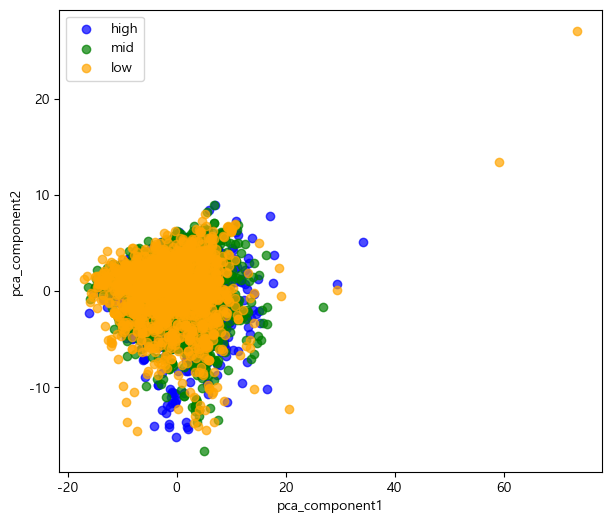

In [ ]:
# 3등분 2D
# pca
fig = plt.figure(figsize=(7, 6))
ax2 = fig.add_subplot(111)

ax2.scatter(X_pca2D[high, 0], X_pca2D[high, 1], label='high', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[mid, 0], X_pca2D[mid, 1], label='mid', c='green', alpha=0.7)
ax2.scatter(X_pca2D[low, 0], X_pca2D[low, 1], label='low', c='orange', alpha=0.7)

ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.legend()

# # 저장
# file_name = f'pca_{dataset}.png'
# file_path = os.path.join(save_dir, file_name)
# print(file_path)
# plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')

plt.show()